In [6]:
%pylab inline
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [12]:
n = 16
FINDER_DIR='/fastdata/finder/'
IMAGE_PATH=FINDER_DIR+'streetview/'
train_dir='../models/m5/'
# IMAGE_PATH=FINDER_DIR+'flickr/'
CLUSTER_FILE=train_dir+'/clusters.npy'


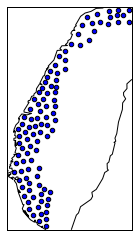

In [8]:
from mpl_toolkits.basemap import Basemap
from sklearn import cluster
bm_param, km_param = np.load(FINDER_DIR+'clusters.npy')
m = Basemap(resolution='i',**bm_param)
m.drawcoastlines()
m.drawcountries()
scatter( *km_param.T )

In [9]:
files = [IMAGE_PATH+l.strip() for l in open(FINDER_DIR+'/streetview_test.txt','r')]
random.shuffle(files)
files = files[:n]

In [11]:
from eval import *
tf.reset_default_graph()
# Setup the graph
with tf.device('/cpu:0') as d:
    data,gt = glocData(files, FINDER_DIR+'clusters.npy', batch_size=1)

    vgg = vgg16(data)
    avg_vgg = tf.reduce_mean(tf.reduce_mean(vgg,1),1)

    pred = tf.argmax(avg_vgg,dimension=1)

    # Initialize ops
    saver = tf.train.Saver(tf.all_variables())
    tf.get_default_graph().finalize()

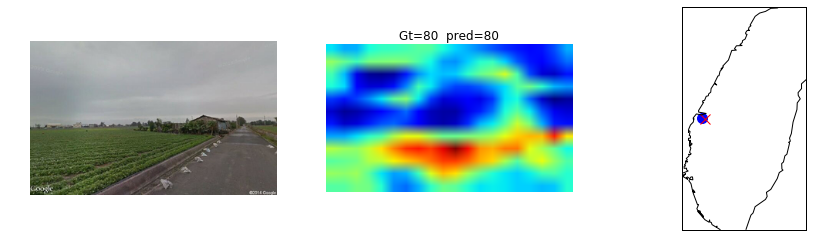

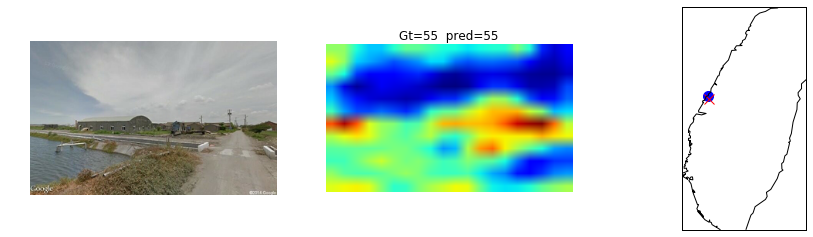

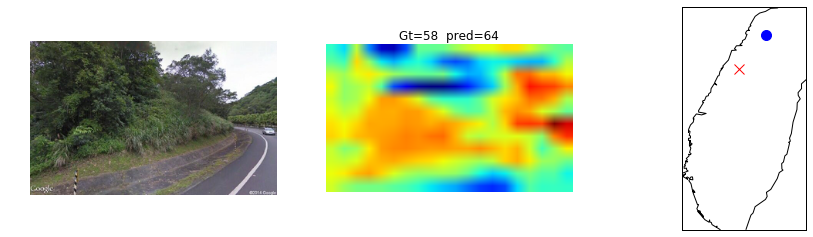

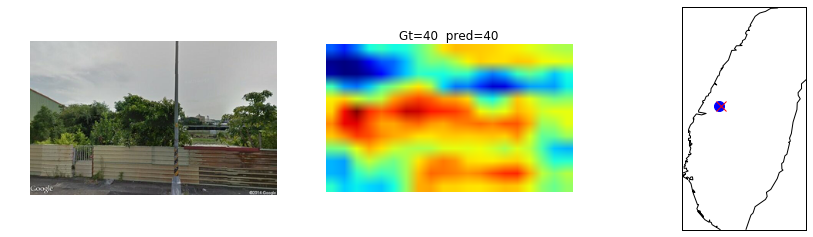

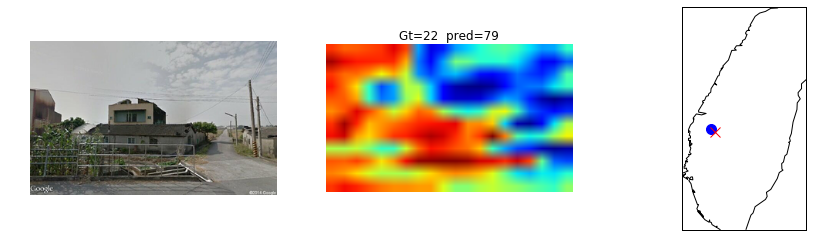

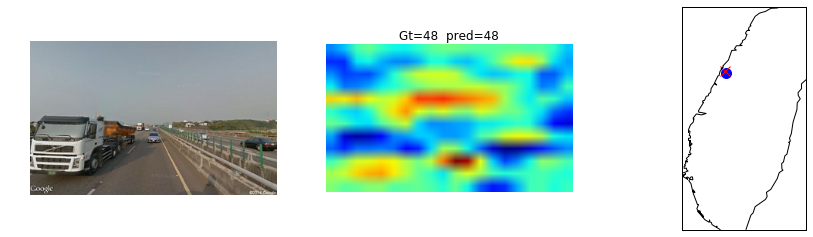

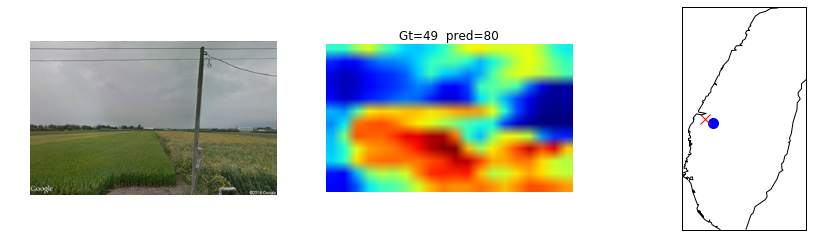

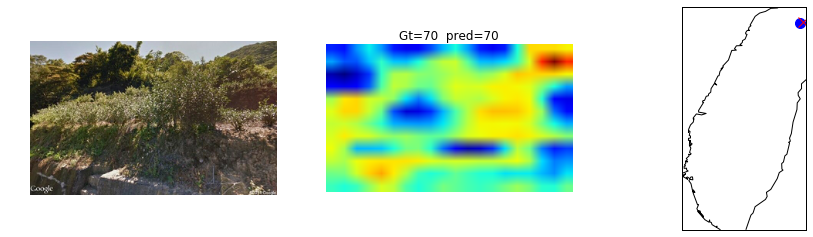

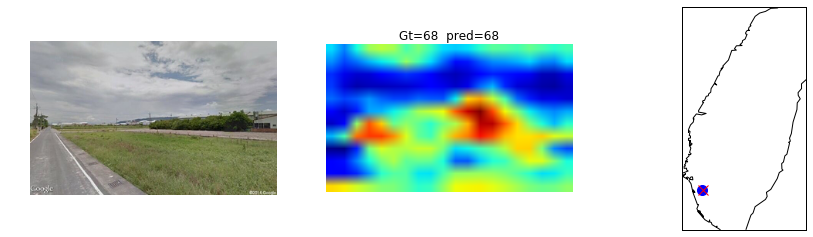

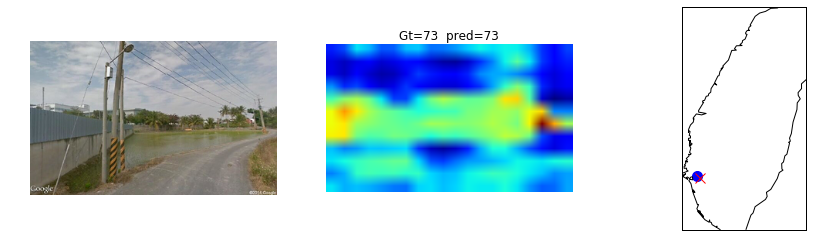

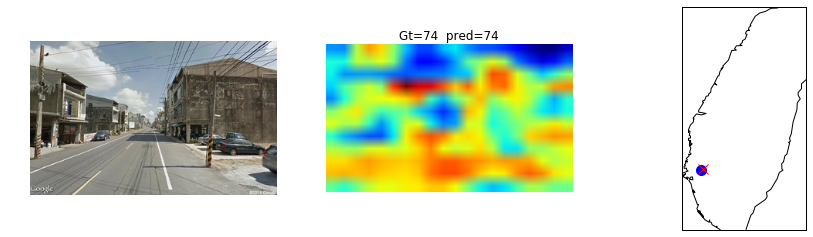

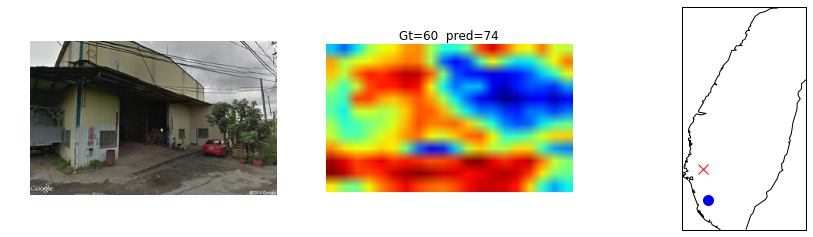

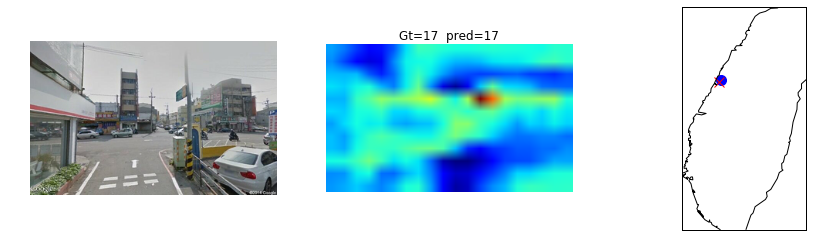

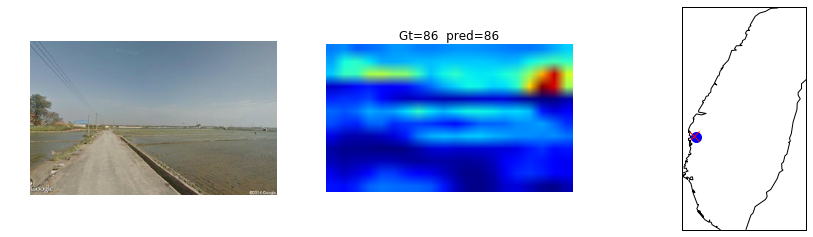

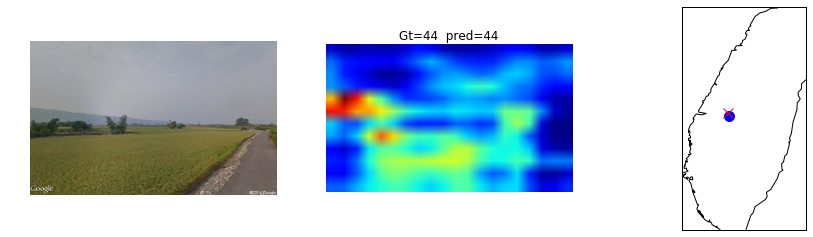

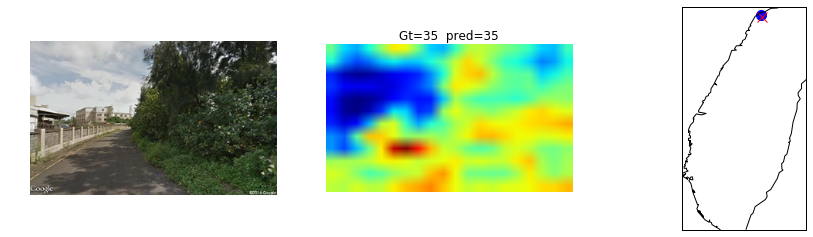

In [13]:
def pm(m):
    mm = m - np.max(m)
    r = np.exp(mm)
    return r / np.sum(r)
lon,lat = tf.get_default_graph().get_tensor_by_name('PyFunc:0'), tf.get_default_graph().get_tensor_by_name('PyFunc:1')
from glob import glob
with tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.3))) as sess:
    # Initialize stuff
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    snap = youngest([f for f in glob(os.path.join(train_dir, 'final.ckpt*')) + glob(os.path.join(train_dir, 'snap.ckpt*')) if '.meta' not in f])
    saver.restore(sess, snap)

    # Eval
    for it in range(n):
        gt_value, pred_value, data_value, vgg_value, lon_value, lat_value = sess.run([gt, pred, data, vgg, lon, lat])
        
        gt_value, pred_value = int(gt_value), int(pred_value)
        lon_value, lat_value = float(lon_value), float(lat_value)
        data_value, vgg_value = data_value[0], vgg_value[0]
        
        figure(figsize=(15,4))
        subplot(1,3,1); imshow((data_value+np.array([123,117,103])[None,None])/255); axis('off')
#         subplot(1,3,2); imshow(np.sum(vgg_value,axis=2)); axis('off')
        subplot(1,3,2); imshow(pm(0.05*vgg_value[:,:,gt_value])); axis('off')
        title('Gt=%d  pred=%d'%(gt_value, pred_value))
        subplot(1,3,3)
        m.drawcoastlines()
        m.drawcountries()
#         scatter( *km_param[gt_value], color='g', s=60 )
        scatter( *m(lat_value,lon_value), color='b', s=100 )
        scatter( *km_param[pred_value], color='r', s=100, marker='x' )
    coord.request_stop()
    coord.join(threads)